# 7. Plots
## 7.2 Light curve plots

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import xarray as xa

from pytransit.utils.misc import fold
from pytransit.lpf.tesslpf import downsample_time

In [3]:
%run src/core.py
%run src/tmlpf.py
%run plotting.py

In [4]:
lpf = TMLPF('toi_263_final')

In [5]:
with xa.open_dataset('results/toi_263_tess_m2_lco.nc') as ds:
    fc = array(ds.lm_mcmc).reshape([-1,ds.name.shape[-1]])
    df = pd.DataFrame(fc, columns=ds.name.values)

In [6]:
pvp = permutation(fc)[:200]
pv = median(pvp, 0)

In [7]:
fm = percentile(lpf.transit_model(pvp), [50, 16, 84], 0)

In [8]:
bl = squeeze(lpf.baseline(pv))

In [9]:
phase = pv[1] * (fold(lpf.timea[:lpf._ntess], pv[1], pv[0], 0.5) - 0.5)
sids = argsort(phase)
phase = phase[sids]
fm_tess = fm[:, :lpf._ntess][:,sids]
fo_tess = lpf.ofluxa[:lpf._ntess][sids]
bl_tess = bl[:lpf._ntess][sids]

In [10]:
pb, fb, eb = downsample_time(phase, fo_tess, 4/24/60)

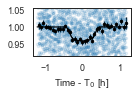

In [11]:
with sb.plotting_context('paper'):
    fig, ax = subplots(figsize=(AAPGW/4,0.75*AAOCW/3), constrained_layout=False)
    ax.plot(24*phase, fo_tess, '.', alpha=0.1)
    ax.fill_between(24*phase, *fm_tess[1:], alpha=0.25)
    ax.errorbar(24*pb, fb, eb, fmt='k.')
    ax.plot(24*phase, fm_tess[0], 'k')
    setp(ax, ylim=(0.915,1.055), xlabel='Time - T$_0$ [h]')

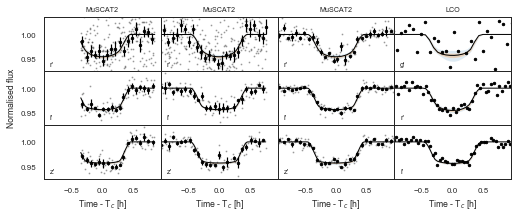

In [15]:
with sb.plotting_context('paper', font_scale=0.9):
    fig, axs = subplots(3, 4, figsize=(AAPGW, 0.85*AAOCW))

    pvp = permutation(fc)[:200]
    pv = median(pvp, 0)
    t0, p = pv[[0,1]]

    fmodel = lpf.transit_model(pvp)
    bmodel = lpf.baseline(pvp)
    fmperc = percentile(fmodel, [50, 16, 84, 2.5, 97.5], 0)
    blmed  = median(bmodel, 0)

    for ia,ax in enumerate(axs.T.flat):
        i = ia + lpf._stess
        t = lpf.times[i]
        e = epoch(t.mean(), t0, p)
        tc = t0 + e*p
        time_h = 24*(t-tc)

        if ia in (0,1,2,3,4,5,6,7,8):
            pbm, fbm, ebm = downsample_time(time_h, lpf.fluxes[i]/blmed[lpf.lcslices[i]], 4/60)
            ax.plot(time_h, lpf.fluxes[i]/blmed[lpf.lcslices[i]], 'k.', ms=2, alpha=0.25)
            ax.errorbar(pbm, fbm, ebm, fmt='k.')
        else:
            ax.plot(time_h, lpf.fluxes[i]/blmed[lpf.lcslices[i]], 'k.')

        ax.text(0.05, 0.1, f"{lpf.passbands[lpf.pbids[i]][0]}'", transform=ax.transAxes, size='small')
        ax.fill_between(time_h, *fmperc[3:5, lpf.lcslices[i]], alpha=0.15)
        ax.fill_between(time_h, *fmperc[1:3, lpf.lcslices[i]], alpha=0.25)
        ax.plot(time_h, fmperc[0, lpf.lcslices[i]], 'k', lw=1)

    [ax.set_title(t, size='small') for ax,t in zip(axs[0,:], 'MuSCAT2 MuSCAT2 MuSCAT2 LCO'.split())];
    
    for ax in axs[:,1:].flat:
        setp(ax.get_yticklabels(), visible=False)

    for ax in axs[:-1,:].flat:
        setp(ax.get_xticklabels(), visible=False)

    setp(axs[-1,:], xlabel='Time - T$_c$ [h]')
    setp(axs[1,0], ylabel='Normalised flux')

    setp(fig.axes, ylim=(0.925, 1.035), xlim=(-0.95,0.95));
    fig.subplots_adjust(wspace=0, hspace=0, left=0.08, right=0.995, bottom=0.15, top=0.91)
    fig.savefig('plots/final_joint_lc_plot.pdf')

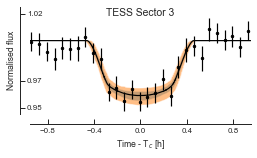

In [47]:
sb.set_style('ticks')
with sb.plotting_context('paper', font_scale=0.9):
    fig, ax = subplots(figsize=(AAOCW, 0.6*AAOCW), constrained_layout=True)

    phase = 24*(pv[1] * (fold(lpf.timea[:lpf._ntess], p, t0, 0.5) - 0.5))
    sids = argsort(phase)
    phase = phase[sids]
    fm_tess = fmperc[:, :lpf._ntess][:,sids]
    fo_tess = lpf.ofluxa[:lpf._ntess][sids]
    bl_tess = blmed[:lpf._ntess][sids]

    pb, fb, eb = downsample_time(phase, fo_tess/bl_tess, 4/60)
    ax.errorbar(pb, fb, eb, fmt='k.')
    ax.fill_between(phase, *fm_tess[1:3], alpha=0.5)
    ax.fill_between(phase, *fm_tess[3:5], alpha=0.5)
    ax.plot(phase, fm_tess[0], 'k')
    
    ax.text(0.5, 0.99, 'TESS Sector 3', size='larger', va='top', ha='center', transform=ax.transAxes)
    setp(ax, yticks=[0.95, 0.97, 1.02], xticks=linspace(-0.8,0.8,5))
    ax.tick_params(axis="y",direction="in", pad=-22)
    ax.tick_params(axis="x",direction="in")
    sb.despine(fig, offset=10)
    setp(ax, ylim=(0.945, 1.025), xlim=(-0.95,0.95), xlabel='Time - T$_c$ [h]', ylabel='Normalised flux');
    fig.savefig('plots/final_tess_lc.pdf')

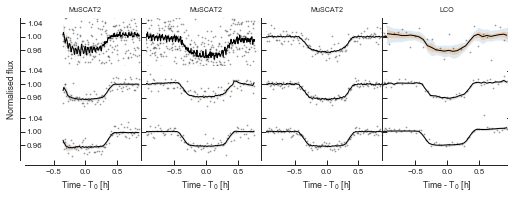

In [55]:
sb.set_style('ticks')
with sb.plotting_context('paper', font_scale=0.9):
    fig, axs = subplots(3, 4, figsize=(AAPGW,0.75*AAOCW), constrained_layout=False, sharex='all', sharey='all')
    fmodel = lpf.flux_model(permutation(df.values)[:500])
    fmperc = percentile(fmodel, [50, 16, 84, 2.5, 97.5], 0)

    t0, p = pv[[0,1]]
    for ia,ax in enumerate(axs.T.flat):
        i = ia + lpf._stess
        t = lpf.times[i]
        e = epoch(t.mean(), t0, p)
        tc = t0 + e*p
        time_h = 24*(t-tc)
        ax.fill_between(time_h, *fmperc[3:5, lpf.lcslices[i]], alpha=0.15)
        ax.fill_between(time_h, *fmperc[1:3, lpf.lcslices[i]], alpha=0.25)
        ax.plot(time_h, fmperc[0, lpf.lcslices[i]], 'k', lw=1)
        ax.plot(time_h, lpf.fluxes[i], 'k.', ms=2, alpha=0.25)
    setp(axs, ylim=(0.915, 1.055), xlim=(-0.95, 0.95), yticks=[0.96, 1.0, 1.04]);
    setp(axs[-1,:], xlabel='Time - T$_0$ [h]')
    axs[1,0].set_ylabel('Normalised flux')
    [ax.set_title(t, size='small') for ax,t in zip(axs[0,:], 'MuSCAT2 MuSCAT2 MuSCAT2 LCO'.split())];
    fig.subplots_adjust(wspace=0, hspace=0, left=0.05, right=0.995, bottom=0.15, top=0.91)
    [ax.tick_params(axis="y",direction="in", pad=-22) for ax in axs.flat]
    [ax.tick_params(axis="x",direction="in") for ax in axs.flat]
    sb.despine(fig, offset=5)
    fig.savefig('plots/final_joint_lc_with_baseline.pdf')

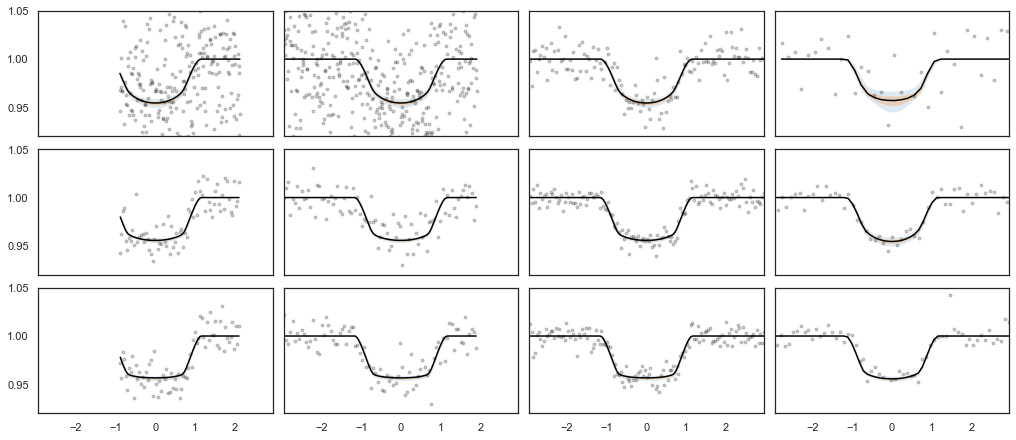

In [15]:
fig, axs = subplots(3, 4, figsize=(14,6), constrained_layout=True, sharex='all', sharey='all')
pvp = permutation(df.values)[:500]
fmodel = lpf.transit_model(pvp)
bmodel = lpf.baseline(pvp)
fmperc = percentile(fmodel, [50, 16, 84, 2.5, 97.5], 0)
blmed  = median(bmodel, 0)

t0, p = pv[[0,1]]
for ia,ax in enumerate(axs.T.flat):
    i = ia + lpf._stess
    t = lpf.times[i]
    e = epoch(t.mean(), t0, p)
    tc = t0 + e*p
    time_h = 60*(t-tc)
    ax.fill_between(time_h, *fmperc[3:5, lpf.lcslices[i]], alpha=0.15)
    ax.fill_between(time_h, *fmperc[1:3, lpf.lcslices[i]], alpha=0.25)
    ax.plot(time_h, fmperc[0, lpf.lcslices[i]], 'k')
    ax.plot(time_h, lpf.fluxes[i]/blmed[lpf.lcslices[i]], 'k.', alpha=0.2)
setp(axs, ylim=(0.92, 1.05), xlim=(-2.95, 2.95));

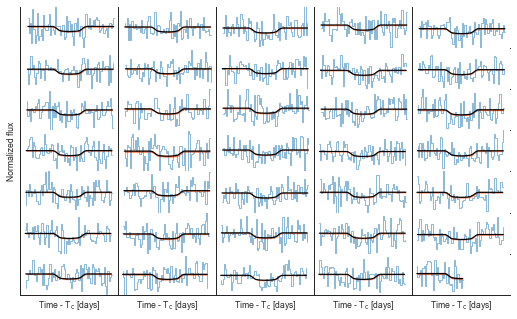

In [56]:
ntr = lpf._stess
ncols = 5
nrows = int(ceil(ntr / ncols))

fmodel = lpf.flux_model(permutation(df.values)[:500])
fmperc = percentile(fmodel, [50, 16, 84, 2.5, 97.5], 0)

epochs = array([epoch(t, pv[0], pv[1]).mean() for t in lpf.times[:lpf._stess]])
tcs = pv[0] + epochs*pv[1]

with sb.plotting_context('paper', font_scale=0.9):

    #fig, axs = subplots(nrows, ncols, figsize=(AAPGW,0.75*AAOCW), constrained_layout=False, sharex='none', sharey='all')
    fig, axs = subplots(nrows, ncols, figsize=(AAPGW, 0.6*AAPGW), constrained_layout=False, sharex='all', sharey='all')
    for i, sl in enumerate(lpf.lcslices[:lpf._stess]):
        ax = axs.flat[i]
        time = lpf.times[i] - tcs[i]
        ax.plot(time, lpf.fluxes[i], drawstyle='steps-mid', alpha=0.5, lw=1)
        ax.plot(time, fmperc[0][sl], 'k')
        ax.fill_between(time, fmperc[1][sl], fmperc[2][sl], alpha=0.75, facecolor='orangered')
    sb.despine(fig)
    setp(axs[3, 0], ylabel='Normalized flux')
    setp(axs[-1, :], xlabel='Time - T$_\mathrm{c}$ [days]')
    setp(axs[:,1:], yticks=[])
    setp(axs[:-1,:], xticks=[])
    setp(axs, ylim=(0.83, 1.17))
    fig.subplots_adjust(wspace=0, hspace=0, left=0.03, right=0.99, bottom=0.05, top=0.99)
    fig.savefig('plots/final_joint_individual_tess_lcs.pdf')

In [ ]:
def plot_individual_tess_transits(self, df, ncols: int = 2, figsize=(14, 8)):
    df = self.posterior_samples(derived_parameters=False)
    pvp = permutation(df.values)[:5000]
    pv = df.median()
    tmodels = self.flux_model(pvp)
    mm = percentile(tmodels, [50, 16, 84, 0.5, 99.5], 0)

    t0 = floor(self.times[0].min())
    nrows = int(ceil(self.nlc / ncols))
    fig, axs = subplots(nrows, ncols, figsize=figsize, sharey=True, constrained_layout=True)
    for i, sl in enumerate(self.lcslices):
        axs.flat[i].plot(self.times[i] - t0, self.fluxes[i], drawstyle='steps-mid', alpha=0.5)
        axs.flat[i].plot(self.times[i] - t0, mm[0][sl], 'k')
        axs.flat[i].fill_between(self.times[i] - t0, mm[1][sl], mm[2][sl], alpha=0.75, facecolor='orangered')
        setp(axs[:, 0], ylabel='Normalized flux')
        setp(axs[-1, :], xlabel=f'Time - {self.bjdrefi + t0:.0f} [days]')
    return fig

---


<center> © 2019 Hannu Parviainen </center>